In [18]:
width = 299
height = 299
channels = 3

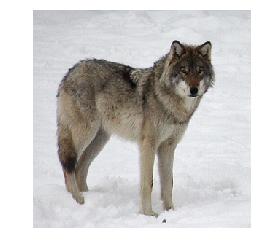

In [19]:
import matplotlib.image as mpimg
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

test_image = mpimg.imread(os.path.join("images", "cnn", "wolf.png"))[:, :, :channels]
plt.imshow(test_image)
plt.axis("off")
plt.show()

In [20]:
test_image = 2 * test_image - 1

In [21]:
import sys
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [22]:
fetch_pretrained_inception_v3()

In [23]:
import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    path = os.path.join("datasets", "inception", "imagenet_class_names.txt")
    with open(path, encoding="utf-8") as f:
        content = f.read()
        return CLASS_NAME_REGEX.findall(content)

In [24]:
class_names = ["background"] + load_class_names()

In [25]:
class_names[:5]

['background',
 'tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri']

In [26]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim
import tensorflow as tf
import numpy as np

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=False)
predictions = end_points["Predictions"]
saver = tf.train.Saver()

In [27]:
with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

INFO:tensorflow:Restoring parameters from datasets\inception\inception_v3.ckpt


In [28]:
X_test = test_image.reshape(-1, height, width, channels)

with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from datasets\inception\inception_v3.ckpt


In [29]:
most_likely_class_index = np.argmax(predictions_val[0])
most_likely_class_index

270

In [30]:
class_names[most_likely_class_index]

'timber wolf, grey wolf, gray wolf, Canis lupus'

In [31]:
top_5 = np.argpartition(predictions_val[0], -5)[-5:]
top_5 = reversed(top_5[np.argsort(predictions_val[0][top_5])])

for i in top_5:
    print("{0}: {1:.2f}%".format(class_names[i], 100 * predictions_val[0][i]))

timber wolf, grey wolf, gray wolf, Canis lupus: 62.49%
coyote, prairie wolf, brush wolf, Canis latrans: 9.00%
red wolf, maned wolf, Canis rufus, Canis niger: 5.82%
dingo, warrigal, warragal, Canis dingo: 2.05%
white wolf, Arctic wolf, Canis lupus tundrarum: 1.90%
